## 1.3 Price Dataset Construction for each Symbol

No premium subscription is needed. Dataset created have a low survivorship bias.

### Importers

In [8]:
if "google.colab" in str(get_ipython()):
  print("***********************************")
  print("Google Colab environment deployment")
  print("***********************************")
  !pip install -r requirements.txt
  from google.colab import drive
  drive.mount('/content/gdrive')
  print("Google Colab environment deployment")
  root = "gdrive/MyDrive/"
else: # local or Paperspace Gradient
  root = ""

In [1]:
# General and Particular Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Price Data related
import re
import yfinance as yf
import nasdaqdatalink
nasdaqdatalink.read_key(filename="data/.my_nq_apikey")

from tqdm.auto import tqdm
import time
from datetime import datetime, timedelta
from pandas_datareader import data as pdr
yf.pdr_override()

# Scraping component timeseries (just tested on local envs)
import requests
from bs4 import BeautifulSoup
import json

# Exceptions handling with pkl component_timeseries
import glob
import os

### Time-Series Components

Caching components from `BlacRock.cl`

In [ ]:
# request page (does not work on Cloud Platforms)
try: # to be integrated/merged with index_compo_webscraper
    html = requests.get("https://www.blackrock.com/cl/productos/239726/#tabsAll").content
    soup = BeautifulSoup(html)

    # find available dates
    holdings = soup.find("div", {"id": "holdings"})
    dates_div = holdings.find_all("div", "component-date-list")[1]
    dates_div.find_all("option")
    dates = [option.attrs["value"] for option in dates_div.find_all("option")]

    # download constituents for each date
    constituents = pd.Series(dtype=object)
    for date in dates:
        resp = requests.get(
            f"https://www.blackrock.com/cl/productos/239726/239726/ishares-core-sp-500-etf/1506433277024.ajax?tab=all&fileType=json&asOfDate={date}"
        ).content[3:]
        tickers = json.loads(resp)
        tickers = [(arr[0], arr[1]) for arr in tickers['aaData']]
        date = datetime.strptime(date, "%Y%m%d")
        constituents[date] = tickers

    constituents = constituents.iloc[::-1] # reverse into cronlogical order
    constituents.head()
    constituents.to_pickle("data/pkl/sp500_component_timeseries.pkl")
except:    
    list_of_pkl_files = glob.glob('data/pkl/IVV*') # * means all if need specific format then *.csv
    latest_file = max(list_of_pkl_files, key=os.path.getctime)
    constituents = pd.read_pickle(root + latest_file)

### Time-Series Prices-Volume Data
#### Nasdaqdatalink API

Downloading Free Data from `nasdaqdatalink` table `WIKI`.

In [ ]:
try:
    first_components_date = constituents.index[0]
    # we substract one-year to start construction of RPMs from this point (we assume static composition from then)
    first_date = first_components_date-timedelta(days=365) 
    first_date = first_date.strftime("%Y-%m-%d")
    """
    https://data.nasdaq.com/databases/WIKIP/documentation?anchor=overview
    Note: As of April 11, 2018 this data feed is no longer actively supported by the Quandl 
    community. We will continue to host this data feed on Quandl, 
    but we do not recommend using it for investment or analysis.
    """
    wikip_last_quarter_supported = "2018-03-31"

    nasdaqdatalink.export_table('WIKI/PRICES', 
        qopts = {'columns': ['ticker', 'date', 'adj_close', 'adj_volume']}, 
        date = {'gte': first_date, 'lte': wikip_last_quarter_supported},
        filename = "data/" + first_date.replace("-","") + "_WIKI_PRICES.zip"
    )    
finally:
    lst_of_zip_wikip_files = glob.glob('data/*WIKI_PRICES*zip')
    latest_file = max(lst_of_zip_wikip_files, key=os.path.getctime)
    wiki = pd.read_csv(root + latest_file, parse_dates=True)    
   
wiki = dict(tuple(wiki.groupby('ticker')))
for ticker in wiki:
    wiki[ticker].set_index("date", inplace=True)

#### Y! Finance API wrapper `yfinance`

Helper functions for the mixing of time-series data. WIKI/PRICES (free dataset) table is restricted till 2018-04-01. Y! Finance quotes (free dataset) is specially sensible to delistings at ealier dates than 2020, thus the mixing with WIKI/PRICES is really needed. 

`rename table` maps obsolete tickers from `BlackRock.cl` into current tickers available at Y! Finance. Is based on `data/abnormal_tickers_to_analyze.csv` which summarizes findings after manual searches on the internet.

In [30]:
import time
import re

yfinance_exceptions = ['GAS', 'HAR', 'CSC', 'EMC', 'GME', 'POM', 'PCL', 'COV', 'ETN', 'COL', 'LLL']
nasdaqdl_exceptions = ['IR']

def change_ticker(ticker):
    rename_table = {
        "-": "LPRAX", # BlackRock LifePath Dynamic Retirement Fund
        "8686": "AFL", # AFLAC
        "4XS": "ESRX", # Express Scripts Holding Company 
        "AAZ": "APC", # Anadarko Petroleum Corporation
        "AG4": "AGN", # Allergan plc
        "BFB": "BF-B", # Brown-Forman Corporation
        "BF.B": "BF-B", # Brown-Forman Corporation
        "BF/B": "BF-B", # Brown-Forman Corporation
        "BF_B" : "BF-B", # Brown-Forman Corporation
        "BLD WI": "BLD", # TopBuild Corp.
        "BRKB": "BRK-B", # Berkshire Hathaway Inc.
        "BRK_B": "BRK-B", # Berkshire Hathaway Inc.
        "CC WI": "CC", # The Chemours Company
        "DC7": "DFS", # Discover Financial Services
        "DWDP": "DD", # Discover Financial Services
        "FB": "META",   # Facebook
        "GGQ7": "GOOG", # Alphabet Inc. Class C
        "GEC": "GE", # General Electric
        "HNZ": "KHC", # The Kraft Heinz Company
        "INCO": "INTC", # Intel
        "LOM": "LMT", # Lockheed Martin Corp.
        "LTD": "LB", # L Brands Inc.
        "LTR": "L", # Loews Corporation        
        "MPN": "MPC", # Marathon Petroleum Corp.
        "MYL": "VTRS", # Mylan NV (VIATRIS)
        "MWZ": "MET", # Metlife Inc.
        "MX4A": "CME", # CME Group Inc.
        "NCRA": "NWSA", # News Corporation
        "NTH": "NOC", # Northrop Grumman Crop.
        "PA9": "TRV", # The Travelers Companies, Inc.
        "QCI": "QCOM", # Qualcomm Inc.
        "RN7": "RF", # Regions Financial Corp
        "RTN" : "RTX", # Raytheon
        "SLBA": "SLB", # Schlumberger Limited
        "SYF-W": "SYF", # Synchrony Financial
        "SWG": "SCHW", # The Charles Schwab Corporation 
        "UAC/C": "UAA", # Under Armour Inc Class A
        "UBSFT": "UBSFY", # Ubisoft Entertainment
        "USX1": "X", # United States Steel Corporation
        "UUM": "UNM", # Unum Group
        "VISA": "V", # Visa Inc         
        "VIAC": "VIA", # viacom
        "WLTW": "WTW" # Willis Towers Watson                
    }
    if ticker in rename_table:
        fix = rename_table[ticker]
    else:
        fix = re.sub(r'[^A-Z]+', '', ticker)
    return fix

def yfinance_data(ticker, start, end):    
    ticker = change_ticker(ticker)
    # abnormal quotes from yfinance or bad mixing with nasdaqdl
    if ticker in yfinance_exceptions: 
        return None    
    try:
        df = pdr.get_data_yahoo(ticker, start, end, progress=False, show_errors=False, timeout=0.5) 
    except:
        time.sleep(1)
        try:            
            df = pdr.get_data_yahoo(ticker, start, end, progress=False, show_errors=False, timeout=0.5)
        except:
            return None
    # adjust close using adj close
    adjfactor = df["Close"] / df["Adj Close"]    
    df["Close"] = df["Adj Close"]
    df["Volume"] *= adjfactor
    df = df.drop(["Adj Close", "Open", "High", "Low"], axis=1)
    df = df.rename(str.lower, axis='columns')
    df.index.rename('date', inplace=True)    
    return df

def nasdaqdl_data(ticker, start, end):    
    # abnormal quotes from yfinance or bad mixing with nasdaqdl (because of splittings a posteriori)
    if ticker in nasdaqdl_exceptions: 
        return None    
    if ticker in wiki:
        df = wiki[ticker][start:end]
    else:
        ticker = change_ticker(ticker)
        if ticker in wiki:
            df = wiki[ticker][start:end]
        else:
            return None
    df = df.drop(['ticker'], axis=1)
    df = df.rename(index=str, columns={"adj_close": "close","adj_volume": "volume"})
    return df

#### Main Procedure (in review)
Daily returns quotes are filled on a conditional time-series basis. 
In this way, `notna()` values only appear the times when the stock is included in the replicating ETF portfolio (e.g. BlackRock `IVV`, the ETF which replicates S&P500)

In [ ]:
from tqdm.auto import tqdm
data = {}
skips = set()

constituents = constituents["2011-06-01":]
"""
Fast Manual Checks for Ticker Price Data Availability
subsetting = ["LLL", "AIV", "VIA", "IR", "LUMN"]                
"""    
subsetting = []                
global_excludes = ["CBE", "TIE", "BMC"]   # bad quotes in both nasdaqdl and yfinance sources

query = []
dates = []

for i in tqdm(range(0, len(constituents) - 1)):
    start = str(constituents.index[i].date())
    end = str((constituents.index[i + 1].to_pydatetime() - timedelta(days=1)).date())

    tickers_supported = 0    
    for counter, company in enumerate(constituents[i]):        
        if change_ticker(company[0]) not in subsetting and len(subsetting)!=0:       
            continue        
        if company[0] in global_excludes: # Company with bad behaviour for Quotes in Y! Finance (TBR)
            continue
        if company in skips:
            continue                
        df = yfinance_data(company[0], start, end);                
        if df is None or df.empty:
            df = nasdaqdl_data(company[0], start, end);                
        if df is None or df.empty:
            skips.add(company)
            continue        
        if change_ticker(company[0]) in data:
            data[change_ticker(company[0])]  = pd.concat([data[change_ticker(company[0])],df])
        else:
            data[change_ticker(company[0])] = df        
        tickers_supported+=1

    print(f"{start}, tickers cached {tickers_supported}")    
    query.append(tickers_supported)        
    dates.append(start)

print(skips)  

In [32]:
pd.DataFrame({"start": dates, "ntickers": query}).to_csv(root + "data/sp500_components_cached.csv", index=False)
skips_df = pd.DataFrame(skips, columns=["ticker", "company"])
skips_df.sort_values(by="ticker").drop_duplicates(subset="ticker").to_csv("data/skips_alltimes.csv", index=False)

In [33]:
for ticker, df in data.items():
    df = df.reset_index().drop_duplicates(subset='date').set_index('date')
    df.to_csv(root + f"data/{change_ticker(ticker)}.csv")
    data[ticker] = df
tickers = [change_ticker(ticker) for ticker in data.keys()]
pd.Series(tickers).to_csv(root + "data/tickers.csv", index=False)

### Further Checks

##### Manual Loading (Offline Reloading) (in review)


1. Catching Symbols

In [3]:
tickers = pd.read_csv("data/tickers.csv", usecols=[1], header=0, names=["symbols"])["symbols"].to_list()

2. Equity Line Construction (Compouding Daily Returns through Time) and Comparison

[*********************100%***********************]  1 of 1 completed


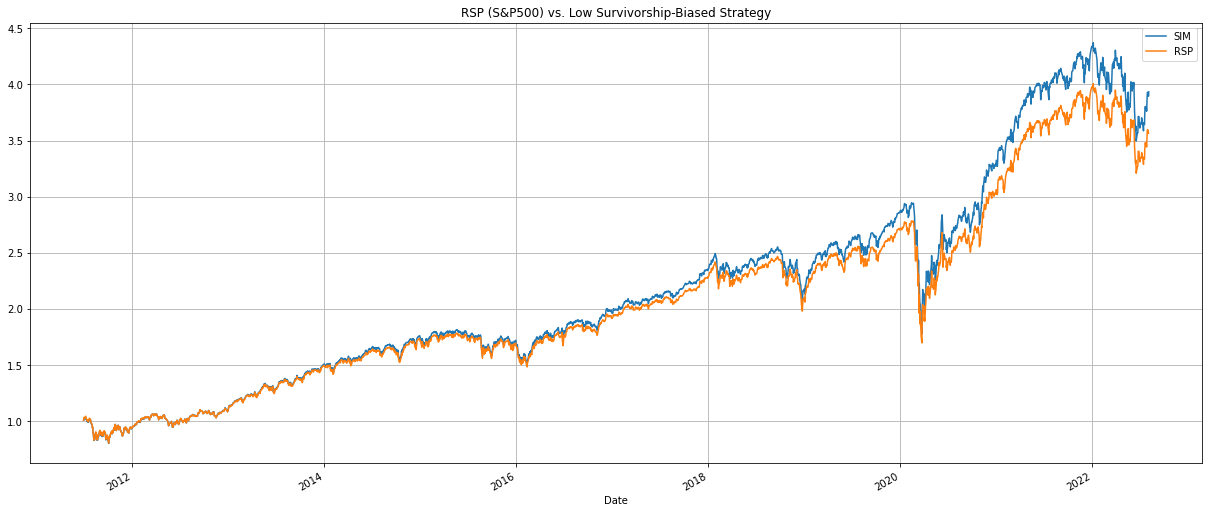

In [6]:
sim_rsp = (
    (pd.concat([pd.read_csv(f"data/{ticker}.csv", index_col='date', parse_dates=True)['close'].pct_change() for ticker in tickers],
        axis=1,
        sort=True,
    ).mean(axis=1, skipna=True) + 1)
    .cumprod()
    .rename("SIM")
)

fee = 0.002/252 # BlackRock ETF annul fee 2% p.a.

rsp = (
    (pdr.get_data_yahoo("RSP", sim_rsp.index[0], sim_rsp.index[-1])["Adj Close"].pct_change() + fee + 1)  
    .cumprod()
    .rename("RSP")
)

sim_rsp.plot(legend=True, title="RSP (S&P500) vs. Low Survivorship-Biased Strategy", figsize=(21, 9))
rsp.plot(legend=True)
plt.grid();

4. Joining all the histories of percent daily returns for Labelling and Features Construction

In [9]:
pictionary = {ticker: pd.read_csv(root + f"data/{ticker}.csv", index_col='date', parse_dates=True)['close'].pct_change() for ticker in tickers}
df = pd.DataFrame(pictionary)

In [16]:
df.iloc[:,:10].head()

,GHC,AZO,CMG,ISRG,SHLDQ,NFLX,GAS,DNB,PCLN,R
date,,,,,,,,,,
2011-06-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-06-30,0.003594,0.012117,0.012251,0.010071,0.025111,-0.008493,NaN,NaN,NaN,0.033636
2011-07-01,0.007781,0.009395,0.024433,0.017576,0.009658,0.020176,0.019406,0.008432,0.025136,0.030783
2011-07-05,-0.006276,-0.001613,0.018149,0.007183,-0.018855,0.080749,0.006024,-0.007525,0.020145,-0.015358
2011-07-06,-0.005291,0.002053,0.010857,-0.001311,0.003109,0.004592,0.006946,0.006318,0.001420,0.004333
